In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision import transforms as T
import torch.autograd as autograd

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm.autonotebook import tqdm
from skimage.color import rgb2lab, lab2rgb
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import train_test_split

#!pip install -qq torchsummary
from torchsummary import summary

In [169]:
# kaggle download issues
# import os
# os.chdir(r'../working')
# from IPython.display import FileLink
# FileLink(r'model.pth')

In [2]:
seed = 42
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
gen = torch.Generator()
gen.manual_seed(seed)

BATCH_SIZE = 8  # 16 for BASE L1/BCE without critical updates, 8 when reserving more memory (reuse graph/more samples)
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
epochs = 8  # set >= 100 if training UNET generator from scratch, else 10-20 epochs
loss_lambda = 100
gp_lambda = 10 # for alt. version with WGAN-GP
ep = 0

PATH = 'model.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


#### Base pandas random sampled dataframe

In [3]:
# dataset (COCO2014 - test): here we use random 17200 of coco samples
coco = glob(r'test2014' + '/*.jpg')
coco = sorted([str(x) for x in coco])

df = pd.DataFrame(data={'color': coco, 'name': np.zeros(len(coco))}).sample(17200)
train, valid = train_test_split(df, test_size=3440, shuffle=True, random_state=seed)
print(f'Train size: {len(train)}, valid size: {len(valid)}')

Train size: 13760, valid size: 3440


#### Full pandas dataframe to use with torch sampler

In [3]:
# alternative - load all instances in df to select subsets by random later with PyTorch sampler
coco = glob(r'test2014' + '/*.jpg')
coco = sorted([str(x) for x in coco])

df = pd.DataFrame(data={'color': coco, 'name': np.zeros(len(coco))})
# clean data from grayscale images
gray_indices = []
for i in range(len(df)):
    img = Image.open(df.loc[i, 'color'])
    if img.mode == 'L':
        gray_indices.append(i)
df.drop(gray_indices, inplace=True)

train, valid = train_test_split(df, test_size=4000, shuffle=True, random_state=seed)
print(f'Train size: {len(train)}, valid size: {len(valid)}')

Train size: 36736, valid size: 4000


#### Augmentations

In [4]:
# advanced augmenatations may be useful, but aware of strong transformations in some cases
train_transforms = A.Compose([A.Resize(height=IMAGE_WIDTH, width=IMAGE_HEIGHT, p=1),
                              A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, 
                                                            sat_shift_limit=0.2, 
                                                            val_shift_limit=0.2, p=0.2),      
                                       A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                                  contrast_limit=0.2, p=0.9)],p=0.2),
                              A.OneOf([A.MotionBlur(p=.2),
                                       A.MedianBlur(blur_limit=3, p=0.1),
                                       A.Blur(blur_limit=3, p=0.1),
                                      ], p=0.2),
                              A.HorizontalFlip(p=0.1),
                              A.VerticalFlip(p=0.1),
                              ],p=1.0,)
final_transforms = ToTensorV2(p=1.0)
valid_transforms = A.Resize(height=IMAGE_WIDTH, width=IMAGE_HEIGHT, p=1)
# btw, as for https://arxiv.org/pdf/2006.02595.pdf paper: augmenting only real images does not impact on gan quality
# or even worsens the results adding artifacts to generated images (talking about vanilla gan)
# improvement comes from augmenting both real and generated images

In [4]:
# or basic transforms (good enough for the given task)
train_transforms = A.Compose([A.Resize(height=IMAGE_WIDTH, width=IMAGE_HEIGHT, p=1),
                              A.HorizontalFlip(p=0.2),
])
final_transforms = ToTensorV2(p=1.0)
valid_transforms = A.Resize(height=IMAGE_WIDTH, width=IMAGE_HEIGHT, p=1)

In [5]:
class ColorDataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        row = self.df.iloc[ix].squeeze()
        color_image = cv2.imread(row['color'])
        color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
        color_image = self.transforms(image=color_image)['image']  # in case of basic transforms change this and below lines
        color_image = np.array(color_image)
        img_lab = rgb2lab(color_image).astype("float32")
        img_lab = final_transforms(image=img_lab)['image']
        L = img_lab[[0], ...] / 50. - 1.
        ab = img_lab[[1, 2], ...] / 110.
        return L, ab
    
    def collate_fn(self, batch):
        L, ab = list(zip(*batch))
        L = [l[None].to(device) for l in L]
        ab = [a_b[None].to(device) for a_b in ab]
        L, ab = [torch.cat(i) for i in [L, ab]]
        return L, ab

In [6]:
train_dataset = ColorDataset(train, train_transforms)
valid_dataset = ColorDataset(valid, valid_transforms)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False, # set False with sampler as it already uses torch.randperm(dataset_indices)
                              collate_fn=train_dataset.collate_fn, 
                              drop_last=True,
                              sampler=RandomSampler(data_source=train_dataset, 
                                                    num_samples=14000,
                                                    replacement=False,
                                                    generator=gen),
                             )
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_dataset.collate_fn, drop_last=True)

#### Function that recreates DataLoader every training epoch (instead of RandomSampler)

In [7]:
def get_new_dataset(epoch):
    df = pd.DataFrame(data={'color': coco, 'name': np.zeros(len(coco))})
    train, valid = train_test_split(df, test_size=3440, shuffle=True, random_state=seed)
    train = train.sample(13760, random_state=epoch)
    train_dataset = ColorDataset(train, train_transforms)
    valid_dataset = ColorDataset(valid, valid_transforms)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                                  collate_fn=train_dataset.collate_fn, drop_last=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                                  collate_fn=valid_dataset.collate_fn, drop_last=True)
    return train_dataloader, valid_dataloader

#### Base UNET model (if not using pretrained models)

In [27]:
# initially batchnorm2d; Dropout may add unnecessary noise - set to False.
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False, instance=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni) if not instance else nn.InstanceNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf) if not instance else nn.InstanceNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64, instance=False):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True, instance=instance)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=False, instance=instance)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block, instance=instance)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True, instance=instance)
    
    def forward(self, x):
        return self.model(x)

#### WGAN-GP discriminator (commented)

In [7]:
# initially no dropout and batchnorm2d (batchnorm and leakyrelu, gelu prevent from vanishing grads)
# instance norm computes learnable parameters for every instance in batch, it is better when instances have diff. distributions
# dropout should be disabled for generator while training the discriminator or at any testing stage
# using batchnorm assuming images have same color distribution
# WGAN-GP paper proposes to avoid batch norm in discriminator with WGAN-GP as batchnorm creates correlations -> LayerNorm 
# Conv > Normalization > Activation > Dropout > Pooling

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # spectral or instance norms? Dropout?
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # InstanceNorm after first conv layer does not preserve the color of image
            
            nn.utils.spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False), n_power_iterations=2),
            #nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            # nn.InstanceNorm2d(128), 
            # nn.BatchNorm2d(128), # if L1Loss & BCE implementation
            nn.LayerNorm([128, 64, 64]), # if WGAN-GP
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            
            nn.utils.spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False), n_power_iterations=2),
            #nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            # nn.InstanceNorm2d(256), 
            # nn.BatchNorm2d(256), # if L1Loss & BCE implementation
            nn.LayerNorm([256, 32, 32]), # if WGAN-GP
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            
            nn.utils.spectral_norm(nn.Conv2d(256, 512, 4, 2, 1, bias=False), n_power_iterations=2),
            #nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            # nn.InstanceNorm2d(512), 
            # nn.BatchNorm2d(512), # if L1Loss & BCE implementation
            nn.LayerNorm([512, 16, 16]), # if WGAN-GP
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid() # uncomment if using binary_cross_entropy loss or use binary_cross_entropy_with_logits (preferable)
        )

    def forward(self, input):
        return self.discriminator(input)

#### L1 + BCE(MSE) discriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.utils.spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False), n_power_iterations=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            
            nn.utils.spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False), n_power_iterations=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            
            nn.utils.spectral_norm(nn.Conv2d(256, 512, 4, 2, 1, bias=False), n_power_iterations=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()  # as performing gan_logit_loss()
        )

    def forward(self, input):
        return self.discriminator(input)

In [9]:
# L1 far not the best, when color space LAB (instead of RGB), - but not significantly: https://arxiv.org/pdf/2204.02980.pdf
criterion_content_loss = nn.L1Loss()
# criterion_content_loss = nn.MSELoss()  # strengthen difference in distance between two instances
# criterion_content_loss = nn.SmoothL1Loss(beta=1.0)  # L1 when |x-y| > beta, L2 (MSE) otherwise

class CustomLoss(nn.Module):
    """
    reconstruction loss: SmoothL1Loss, compares G(L) and ab
    perceptual loss: L1Loss, applied to VGG outputs (VGG extracted feature maps)
    total_loss: reconstruction_loss + coef * perceptual_loss
    """
    def __init__(self, coef=0.1):
        super(CustomLoss, self).__init__()
        self.coef = coef
        self.backbone = torchvision.models.vgg19(pretrained=True, progress=False).features[:15].to(device)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.rec_loss_fn = nn.functional.smooth_l1_loss
        self.per_loss_fn = nn.functional.l1_loss
        self.transforms = ToTensorV2(p=1.0)
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device))
        
    def forward(self, L, ab, gl):
        self.backbone.eval()
        reconstruction_loss = self.rec_loss_fn(gl, ab)
        
        L = (L + 1) * 50
        ab = ab * 110
        gl = gl * 110
        real_image = torch.cat([L, ab], dim=1)
        fake_image = torch.cat([L, gl], dim=1)
        
        real = real_image.detach().cpu().numpy()
        fake = fake_image.detach().cpu().numpy()
        real = np.transpose(real, (0, 2, 3, 1))
        fake = np.transpose(fake, (0, 2, 3, 1))

        for i in range(real.shape[0]):
            real[i] = lab2rgb(real[i])
            real_image[i] = self.transforms(image=real[i])['image'].to(device)/255.
            
            fake[i] = lab2rgb(fake[i])
            fake_image[i] = self.transforms(image=fake[i])['image'].to(device)/255.

        input_ = (real_image - self.mean) / self.std
        target = (fake_image - self.mean) / self.std
        input_ = nn.functional.interpolate(input_, mode='bilinear', size=(224, 224), align_corners=False)
        target = nn.functional.interpolate(target, mode='bilinear', size=(224, 224), align_corners=False)
        fake_feature_map = self.backbone.forward(input_)
        real_feature_map = self.backbone.forward(target)
        
        perceptual_loss = self.per_loss_fn(fake_feature_map, real_feature_map)
        
        return reconstruction_loss + self.coef * perceptual_loss

# criterion_content_loss = CustomLoss()
    
# here proposed one-sided label smoothing. It is often assumed to smooth only POSITIVE labels in 'D' model_type.
# uncomment for two-sided (https://arxiv.org/pdf/1606.03498.pdf)
def gan_loss(model_type, smoothing=False, **kwargs):
    if model_type == 'G':
        recon_discriminator_out = kwargs['recon_discriminator_out']
        if smoothing:
            return nn.functional.binary_cross_entropy(recon_discriminator_out, 
                                                      torch.full_like(recon_discriminator_out, np.random.uniform(0.95, 1.)))
        else:
            return nn.functional.binary_cross_entropy(recon_discriminator_out, torch.ones_like(recon_discriminator_out))

    elif model_type == 'D':
        color_discriminator_out = kwargs['color_discriminator_out']
        recon_discriminator_out = kwargs['recon_discriminator_out']
        if smoothing:
            real_loss = nn.functional.binary_cross_entropy(color_discriminator_out, 
                                                           torch.full_like(color_discriminator_out, 
                                                                           np.random.uniform(0.8, 1.0)))  # 0.9
            fake_loss = nn.functional.binary_cross_entropy(recon_discriminator_out, 
                                                           torch.full_like(recon_discriminator_out, 
                                                                           np.random.uniform(0.001, 0.05)))
        else:
            real_loss = nn.functional.binary_cross_entropy(color_discriminator_out, torch.ones_like(color_discriminator_out))
            fake_loss = nn.functional.binary_cross_entropy(recon_discriminator_out, torch.zeros_like(recon_discriminator_out))
        return (real_loss + fake_loss) / 2.0

# do not forget to remove nn.Sigmoid from discriminator, prefered hard smooth_real_value=0.9 for BCE
# MSELoss improves image quality: https://arxiv.org/pdf/1611.04076.pdf
def gan_logit_loss(model_type, smoothing=False, func=nn.functional.mse_loss, smooth_real_value=1.02, **kwargs):
    if model_type == 'G':
        recon_discriminator_out = kwargs['recon_discriminator_out']
        return func(recon_discriminator_out, torch.ones_like(recon_discriminator_out))

    elif model_type == 'D':
        color_discriminator_out = kwargs['color_discriminator_out']
        recon_discriminator_out = kwargs['recon_discriminator_out']
        if smoothing:
            smooth_real_value = np.random.uniform(0.8, 1.0) if smooth_real_value == 'soft' else smooth_real_value
            real_loss = func(color_discriminator_out, torch.full_like(color_discriminator_out, smooth_real_value))
        else:
            real_loss = func(color_discriminator_out, torch.ones_like(color_discriminator_out))
        fake_loss = func(recon_discriminator_out, torch.zeros_like(recon_discriminator_out))
        return (real_loss + fake_loss) / 2.0
    
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1, 0.02)
        nn.init.zeros_(m.bias)

In [10]:
# if using generator from scratch - uncomment
# generator = Unet(input_c=1, output_c=2, n_down=8, num_filters=64, instance=False).apply(init_weights).to(device)
discriminator = Discriminator().apply(init_weights).to(device)

* initially lr_G = lr_D = 2e-4, betas=(0.5, 0.999)
* the bigger batch_size the bigger learning rate
* for WGAN-GP: LR = 1e-4, betas=(0, 0.9), for D weight_decay = 1e-3, optionally changed LRG = 5e-5 after 6 epochs
* TTUR (two-time scale update rule): use lower learning rate for generator than discriminator, e.g. 1e-4, 4e-4, prop. 2e-4, 4e-4
* some papers propose torch.optim.SGD(discriminator.parameters(), lr=1e-4) for simplicity of classifying and constant LR usage


In [48]:
#optimizerG = torch.optim.AdamW(generator.parameters(), lr=1e-4, betas=(0., 0.9)) #, amsgrad=True)
#optimizerD = torch.optim.AdamW(discriminator.parameters(), lr=1e-4, betas=(0., 0.9), weight_decay=1e-3) #, amsgrad=True)

optimizerG = torch.optim.AdamW(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))  # G1e-4 and D4e-4 or G2e-4 and D4e-4
optimizerD = torch.optim.AdamW(discriminator.parameters(), lr=4e-4, betas=(0.5, 0.999))

# Optionally include schedulers # Adam applies lr_decay internally but we can manage upper lr bound
#schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=20, gamma=0.5)
#schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=20, gamma=0.5)
#schedulerD = torch.optim.lr_scheduler.LambdaLR(optimizerD, lr_lambda=lambda epoch: 1 if epoch <= 40 else 0.5, verbose=True)

In [47]:
summary(generator, (1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [48]:
summary(discriminator, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
         LayerNorm-4          [-1, 128, 64, 64]       1,048,576
         LeakyReLU-5          [-1, 128, 64, 64]               0
           Dropout-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,288
         LayerNorm-8          [-1, 256, 32, 32]         524,288
         LeakyReLU-9          [-1, 256, 32, 32]               0
          Dropout-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 16, 16]       2,097,152
        LayerNorm-12          [-1, 512, 16, 16]         262,144
        LeakyReLU-13          [-1, 512, 16, 16]               0
          Dropout-14          [-1, 512,

In [11]:
def grad_req(model, is_required=True):
    for param in model.parameters():
        param.requires_grad = is_required

def PSNR(fake_image, real_image):
    mse = torch.mean((fake_image - real_image) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 110  # max pix for skimage L{AB} 
    return 10 * np.log10(PIXEL_MAX ** 2 / mse)

# for future investigation: SSIM, FID quality measurement?

#### Base train/valid functions

In [11]:
def train_one_batch(generator, discriminator, data, criterion_content_loss, optimizerG, optimizerD):
    generator.train()
    discriminator.train()

    L, ab = data

    fake_color = generator(L)
    grad_req(discriminator, True)
    
    fake_image = torch.cat([L, fake_color], dim=1)
    fake_preds = discriminator(fake_image.detach())
    
    optimizerD.zero_grad()

    real_image = torch.cat([L, ab], dim=1)
    real_preds = discriminator(real_image)
    kwargs = {
              'color_discriminator_out': real_preds, 
              'recon_discriminator_out': fake_preds,  
             }
    d_loss = gan_loss('D', **kwargs)
    d_loss.backward()
    optimizerD.step()

    grad_req(discriminator, False)
    optimizerG.zero_grad()
    
    fake_image = torch.cat([L, fake_color], dim=1)
    fake_preds = discriminator(fake_image)
    
    kwargs = {
              'recon_discriminator_out': fake_preds, 
              }    
    g_loss_gan = gan_loss('G', **kwargs)
    loss_G_L1 = criterion_content_loss(fake_color, ab) * loss_lambda
    g_loss = g_loss_gan + loss_G_L1
    g_loss.backward()
    optimizerG.step()

    torch.nn.utils.clip_grad_norm_(generator.parameters(), 10.0)
    torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 10.0)
    
    with torch.no_grad():
        denorm_fake_color = fake_color.detach().cpu() * 110
        denorm_real_color = ab.detach().cpu() * 110
    metric = PSNR(denorm_fake_color, denorm_real_color)

    return d_loss.item(), g_loss.item(), metric

@torch.no_grad()
def validate(generator, discriminator, data, criterion_content_loss):
    generator.eval()
    discriminator.eval()

    L, ab = data
    
    fake_color = generator(L)
    fake_image = torch.cat([L, fake_color], dim=1)
    real_image = torch.cat([L, ab], dim=1)
    
    color_discriminator_out = discriminator(real_image)
    recon_discriminator_out = discriminator(fake_image)
    kwargs = {
              'color_discriminator_out': color_discriminator_out, 
              'recon_discriminator_out': recon_discriminator_out,  
             }
    d_loss = gan_loss('D', **kwargs)
    
    kwargs = {
              'recon_discriminator_out': recon_discriminator_out, 
              }    
    g_loss_gan = gan_loss('G', **kwargs) 
    loss_G_L1 = criterion_content_loss(fake_color, ab) * loss_lambda 
    g_loss = g_loss_gan + loss_G_L1
    
    denorm_fake_color = fake_color.detach().cpu() * 110
    denorm_real_color = ab.detach().cpu() * 110
    metric = PSNR(denorm_fake_color, denorm_real_color)

    return d_loss.item(), g_loss.item(), metric

#### Alternative: WGAN-GP

In [12]:
CONV3_3_IN_VGG_19 = torchvision.models.vgg19(pretrained=True, progress=False).features[:15].to(device)

def PSNR(fake_image, real_image):
    mse = torch.mean((fake_image - real_image) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 110
    return 10 * np.log10(PIXEL_MAX ** 2 / mse)

class WGANLoss(nn.Module):
    def forward(self, mtype, **kwargs):
        if mtype == 'G':
            fake_preds = kwargs['fake_preds']
            return -fake_preds.mean()

        elif mtype == 'D':  
            gp_lambda = kwargs['gp_lambda']
            interpolates = kwargs['interpolates']
            interpolates_discriminator_out = kwargs['interpolates_discriminator_out']
            real_discriminator_out = kwargs['real_discriminator_out']
            fake_discriminator_out = kwargs['fake_discriminator_out']

            wgan_loss = fake_discriminator_out.mean() - real_discriminator_out.mean()

            gradients = autograd.grad(outputs=interpolates_discriminator_out, 
                                      inputs=interpolates,
                                      grad_outputs=torch.ones(interpolates_discriminator_out.size()).to(device),
                                      retain_graph=True,
                                      create_graph=True)[0]
            gradient_penalty = ((gradients.view(gradients.size(0), -1).norm(2, dim=1) - 1) ** 2).mean()

            return wgan_loss, gp_lambda * gradient_penalty

class ContentLoss(nn.Module):
    def forward(self, fake_image, real_image, model=CONV3_3_IN_VGG_19):
        fake_feature_map = model.forward(fake_image)
        real_feature_map = model.forward(real_image).detach()
        loss = nn.functional.mse_loss(fake_feature_map, real_feature_map)
        return loss
    
criterion_wgan = WGANLoss()
criterion_content = ContentLoss()

In [13]:
def train_one_batch(generator, discriminator, data, criterion_content, optimizerG, optimizerD, critic_updates=5, noise=False):
    generator.train()
    discriminator.train()

    L, ab = data

    grad_req(discriminator, True)
    
    d_loss = 0
    for _ in range(critic_updates):
        fake_color = generator(L)
        fake_image = torch.cat([L, fake_color], dim=1)
        real_image = torch.cat([L, ab], dim=1)

        fake_preds = discriminator(fake_image.detach())
        real_preds = discriminator(real_image) # detach()
        
        optimizerD.zero_grad()

        alpha = np.random.random()
        interpolates = alpha * real_image + (1 - alpha) * fake_image
        #interpolates = (alpha * real_image.detach() + (1 - alpha) * fake_image.detach()).requires_grad_(True)
        interpolates_discriminator_out = discriminator(interpolates)
        
        kwargs = {
                  'gp_lambda': gp_lambda,
                  'interpolates': interpolates, 
                  'interpolates_discriminator_out': interpolates_discriminator_out, 
                  'real_discriminator_out': real_preds, 
                  'fake_discriminator_out': fake_preds,  
                  }
        wgan_loss_d, gp_d = criterion_wgan('D', **kwargs)
        discriminator_loss_per_update = wgan_loss_d + gp_d
        discriminator_loss_per_update.backward(retain_graph=True)
        optimizerD.step()
        d_loss += discriminator_loss_per_update.item()
    d_loss /= critic_updates

    grad_req(discriminator, False)
    optimizerG.zero_grad()

    fake_color = generator(L) ## or comment to use from the last critic update 
    fake_image = torch.cat([L, fake_color], dim=1)
    fake_preds = discriminator(fake_image)
    
    kwargs = {
              'fake_preds': fake_preds, 
              }    
    g_loss_gan = criterion_wgan('G', **kwargs)
    loss_G_L1 = criterion_content(fake_image, real_image) * loss_lambda
    g_loss = g_loss_gan + loss_G_L1
    g_loss.backward()
    optimizerG.step()

    # if not using gradient penalty, add torch.clamp(discriminator.params, -0.01, 0.01) or normalized clamp as above
    #torch.nn.utils.clip_grad_norm_(generator.parameters(), 10.0)
    #torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 10.0)
    
    with torch.no_grad():
        denorm_fake_color = fake_color.detach().cpu() * 110
        denorm_real_color = ab.detach().cpu() * 110
    metric = PSNR(denorm_fake_color, denorm_real_color)

    return d_loss, g_loss.item(), metric

@torch.no_grad()
def validate(generator, discriminator, data, criterion_content):
    generator.eval()
    discriminator.eval()

    L, ab = data
    
    fake_color = generator(L)
    fake_image = torch.cat([L, fake_color], dim=1)
    real_image = torch.cat([L, ab], dim=1)
    
    color_discriminator_out = discriminator(real_image)
    recon_discriminator_out = discriminator(fake_image)

    d_loss = recon_discriminator_out.mean() - color_discriminator_out.mean()
    
    kwargs = {
              'fake_preds': recon_discriminator_out, 
              }    
    g_loss_gan = criterion_wgan('G', **kwargs)
    loss_G_L1 = criterion_content(fake_image, real_image) * loss_lambda
    g_loss = g_loss_gan + loss_G_L1
    
    denorm_fake_color = fake_color.detach().cpu() * 110
    denorm_real_color = ab.detach().cpu() * 110
    metric = PSNR(denorm_fake_color, denorm_real_color)

    return d_loss.item(), g_loss.item(), metric

#### end alternatve part

In [12]:
@torch.no_grad()
def test_show(model):
    model.eval()
    ix = np.random.randint(len(valid))
    L, ab = valid_dataset[ix]
    L, ab = torch.Tensor(L).unsqueeze(0).to(device), torch.Tensor(ab).unsqueeze(0).to(device)
    out = model(L) # generator
    L = (L + 1) * 50
    ab = ab * 110
    out = out * 110
    true_image = lab2rgb(torch.cat([L, ab], dim=1).squeeze().detach().cpu().numpy(), channel_axis=0).transpose(1,2,0)
    black_image = L.detach().cpu().numpy().squeeze()
    out_image = lab2rgb(torch.cat([L, out], dim=1).squeeze().detach().cpu().numpy(), channel_axis=0).transpose(1,2,0)
    plt.figure(figsize=(12,14))
    plt.subplot(131)
    plt.title('Black')
    plt.imshow(black_image, cmap='gray')
    plt.subplot(132)
    plt.title('Colored')
    plt.imshow(true_image)
    plt.subplot(133)
    plt.title('Black Colored')
    plt.imshow(out_image)
    plt.tight_layout()
    plt.show()
    plt.pause(0.001)

In [13]:
try:
    checkpoint = torch.load('model.pth')  # W + PATH fow wgan-gp, MSE_ for MSEmodel
    ep, generator, discriminator, optimizerG, optimizerD = tuple(checkpoint.values())
except:
    ep = 0
ep += 1

In [ ]:
# attempt to add spectral norm to already trained discriminator. SKIP if discriminator has spectralnorm initially
# for name, child in discriminator.named_children():
#     for i, ch in enumerate(child[1:-2]):
#         if isinstance(ch, nn.Conv2d):
#             print(ch)
#             ch = nn.utils.spectral_norm(ch, n_power_iterations=2)

Epoch 1/8


Train D loss: 0.6435, train G loss: 9.4460, PSNR: 19.3149


Validation D loss: 0.7046, validation G loss: 8.7775, PSNR: 18.4785
--------------------------------------------------
Epoch 2/8


Train D loss: 0.5952, train G loss: 9.6024, PSNR: 15.9150


Validation D loss: 0.7383, validation G loss: 9.9981, PSNR: 18.5478
--------------------------------------------------


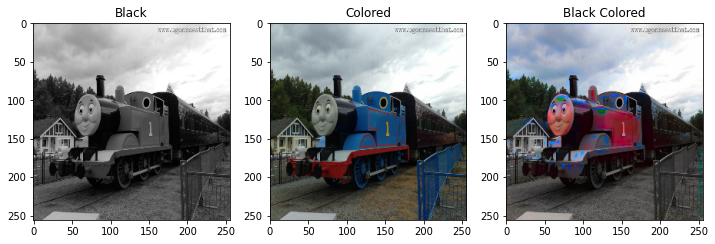

Epoch 3/8


Train D loss: 0.5949, train G loss: 9.5952, PSNR: 16.9967


Validation D loss: 0.7029, validation G loss: 9.4865, PSNR: 18.3933
--------------------------------------------------
Epoch 4/8


Train D loss: 0.5953, train G loss: 9.5741, PSNR: 15.7325


Validation D loss: 0.6684, validation G loss: 9.1702, PSNR: 18.5965
--------------------------------------------------


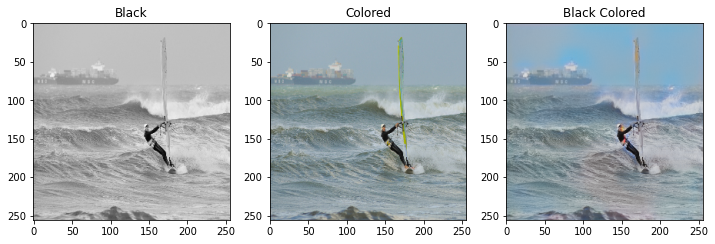

Epoch 5/8


Train D loss: 0.5942, train G loss: 9.5550, PSNR: 19.3977


Validation D loss: 0.7152, validation G loss: 9.4846, PSNR: 18.7280
--------------------------------------------------
Epoch 6/8


Train D loss: 0.5977, train G loss: 9.4582, PSNR: 20.1719


Validation D loss: 0.6465, validation G loss: 8.9916, PSNR: 18.4837
--------------------------------------------------


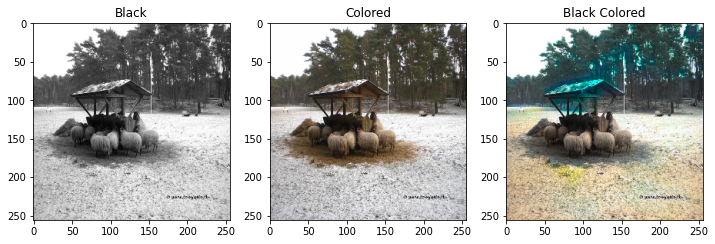

Epoch 7/8


Train D loss: 0.5967, train G loss: 9.4909, PSNR: 18.3855


Validation D loss: 0.6748, validation G loss: 9.8844, PSNR: 17.9625
--------------------------------------------------
Epoch 8/8


Train D loss: 0.5988, train G loss: 9.4105, PSNR: 17.6866


Validation D loss: 0.6922, validation G loss: 9.4890, PSNR: 18.6298
--------------------------------------------------


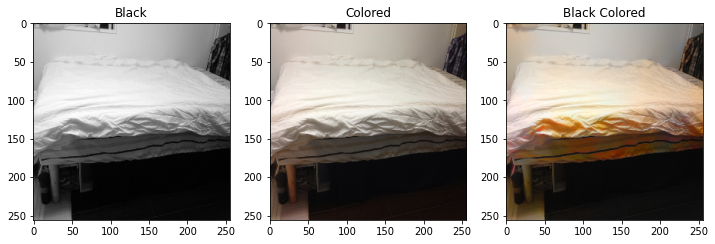

CPU times: total: 14h 45min 24s
Wall time: 2h 23min 50s


In [49]:
%%time
train_d_losses, train_g_losses, valid_d_losses, valid_g_losses = [], [], [], []
mode = 'wgan'
std = 0.5

for epoch in range(ep, epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    #upd = 1 if epoch % 3 == 0 else 2
    #upd = 5 if mode == 'wgan' else 2  # WGAN-GP paper proposed 5 updates 
    
    upd = 1  # number of discriminator updates per batch
    std *= 0.4  # noise decay
    # train_dataloader, valid_dataloader = get_new_dataset(epoch)  # seems like some analogue to augmentations
    
    train_epoch_d_loss, train_epoch_g_loss = [],[]
    for _, data in enumerate(tqdm(train_dataloader, leave=False)):
        d_loss, g_loss, metric = train_one_batch(generator, 
                                                 discriminator, 
                                                 data, 
                                                 criterion_content_loss, 
                                                 optimizerG, 
                                                 optimizerD, 
                                                 critic_updates=upd, 
                                                 std=std,
                                                 noise=False) # modified function
        train_epoch_d_loss.append(d_loss)
        train_epoch_g_loss.append(g_loss)
    epoch_d_loss = np.array(train_epoch_d_loss).mean()
    epoch_g_loss = np.array(train_epoch_g_loss).mean()
    train_d_losses.append(epoch_d_loss)
    train_g_losses.append(epoch_g_loss)
    print(f'Train D loss: {epoch_d_loss:.4f}, train G loss: {epoch_g_loss:.4f}, PSNR: {metric:.4f}')

    valid_epoch_g_loss, valid_epoch_d_loss = [],[]
    for _, data in enumerate(tqdm(valid_dataloader, leave=False)):
        d_loss, g_loss, metric = validate(generator, 
                                          discriminator, 
                                          data, 
                                          criterion_content_loss)
        valid_epoch_g_loss.append(g_loss)
        valid_epoch_d_loss.append(d_loss)
    epoch_g_loss = np.array(valid_epoch_g_loss).mean()
    epoch_d_loss = np.array(valid_epoch_d_loss).mean()
    valid_g_losses.append(epoch_g_loss)
    valid_d_losses.append(epoch_d_loss)
    print(f'Validation D loss: {epoch_d_loss:.4f}, validation G loss: {epoch_g_loss:.4f}, PSNR: {metric:.4f}')
    print('-'*50)    
    
    # Optionally include schedulers
    # schedulerD.step()
    # schedulerG.step()
    if (epoch + 1) % 2 == 0:
        checkpoint = {
                      'epoch': epoch,     
                      'G': generator,
                      'D': discriminator,
                      'optimizerG': optimizerG,
                      'optimizerD': optimizerD,
                      }
        torch.save(checkpoint, PATH)  # PATH for L1 + BCE, MSE_PATH, W_PATH
        test_show(generator)

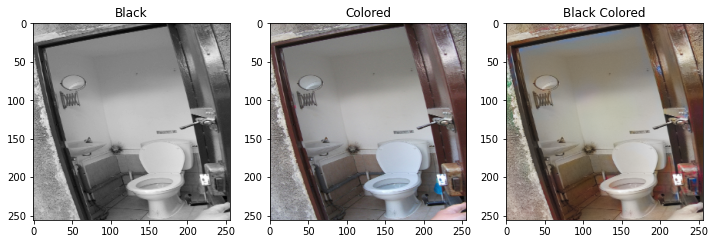

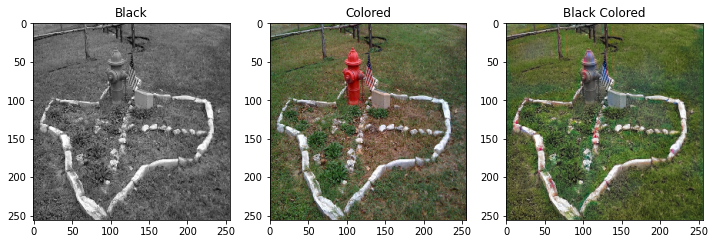

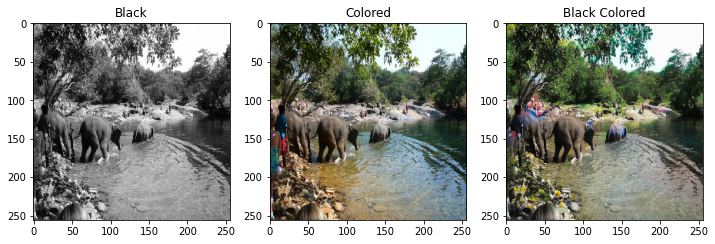

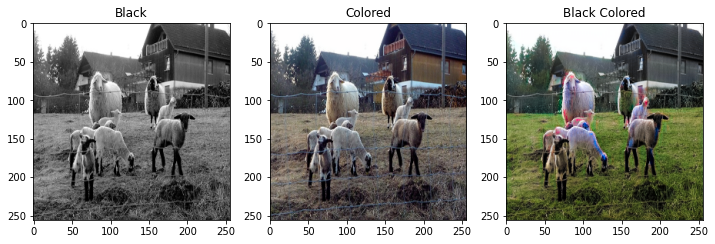

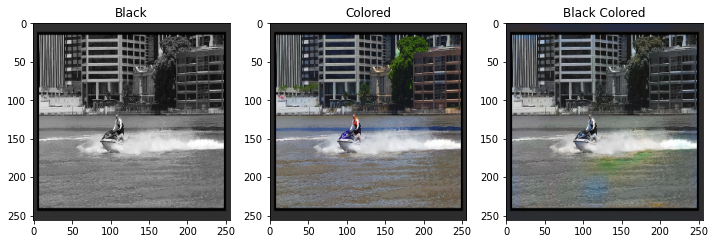

In [20]:
for _ in range(5): # MSE (G2e-4, D2e-4) - 8 epochs, no smoothing or noise or additional updates
    test_show(generator)

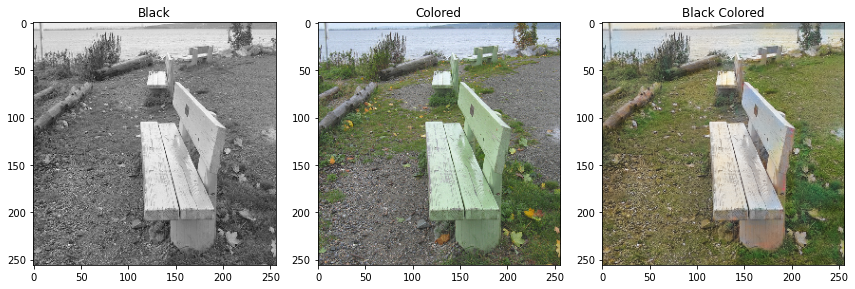

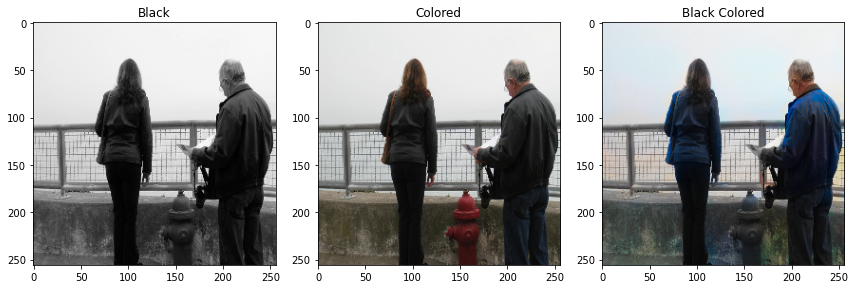

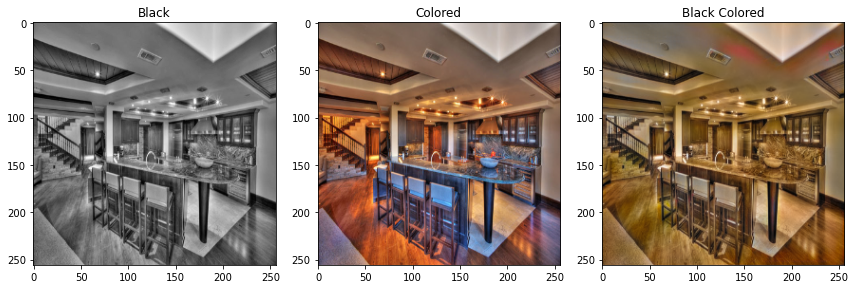

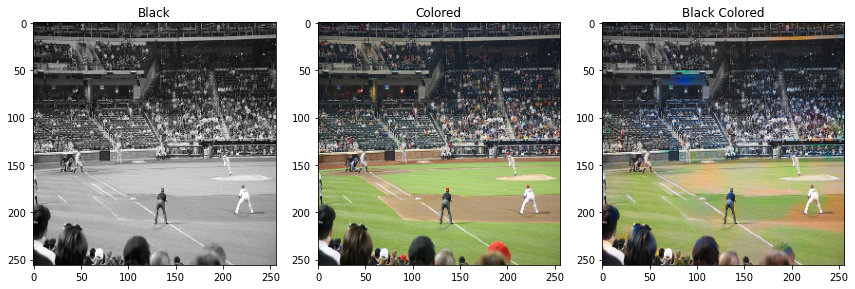

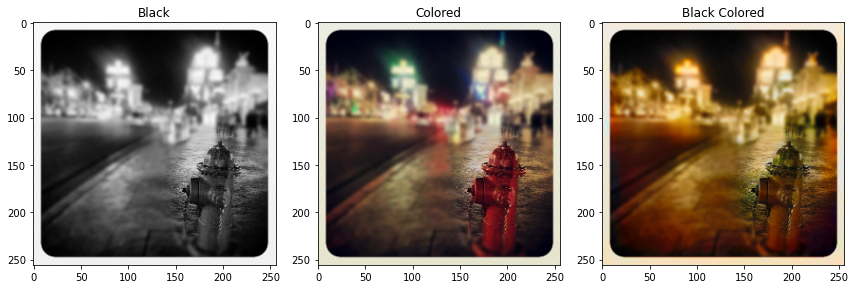

In [16]:
for _ in range(5): # BCE, TTUR (G2e-4, D4e-4) + soft real_label smoothing (8 epochs)
    test_show(generator)

**FIRST RESULTS. To the 38 epoch (with BCE and L1 loss, base) we have: discriminator loss increasing over epochs, while generator loss decreases. One possible reason is: the discriminator starts detecting fake (generated) images as real. Thus, generator loss (first part: D(fake, 1)) begins to decrease a bit, while discriminator fake loss increases (D(fake, 0)). This is not good as generator then begins to generate the same bad quality images as even such similar outputs can fool discriminator. Mode collapse**
* decrease learning rate(s) and (or) modify train function to train discriminator twice (or more) before generator?
* as experiment: change number of discriminator updates every 3 epoch to 1 or zero (if using modified function)
* next apply spectral normalization to Conv2ds (BatchNorms apply to feature maps, Spectral - to layer's parameters - weights).

**If making it from scratch**
* make more complex discriminator model and retrain, maybe with InstanceNorm (make Gaussian distr. on every 'image')?
* do not pretrain generator and use basic unet without dropout (that adds more noise than stability)?
* apply gradient penalty (and multiple updates if necessary) in discriminator or (and) spectral norm?
* uncomment dropout layers in discriminator architecture and set p=0.5 (randomly switch off 50% of neurons)

#### As for now the best visual result gave:
* Pretrained resnet18 generator on 20 epochs and same dataloader as for GAN model
* Discriminator with spectral norm, batch norm and dropout + sigmoid
* LR = 2e-4 both with AdamW, batch_size=16, COCO dataset ~ 12k images without augmentations (only horizontalflip)
* train without noise and multiple discriminator updates
* train with one-sided smoothing with BCE
* train 10 epochs - then generator starts collapsing
* LOSS: L1 for UNET + BCE for discriminator
----------------------------------------------------------

#### Also tried
* WGAN-GP with multiple updates (Batch or LayerNorm)
* BCE+L1 single and multiple updates with and without noise with and without label smoothing (including two-sided)
* BCE+L1 on discriminator without dropout and BatchNorm (or InstanceNorm)


* MiniBatchDiscrimination or learning rate fine-tunning?


* add new datasets every epoch? if discriminator outperforms -> use smooth (1 -> 0.9) and (or) noise. Assuming loss for real data in discriminator would decrease while applying smoothing in MSELoss, discriminator would be more confident in real data, so maybe we should use reverse smoothing with MSELoss (1 -> 1.02)


* Pretrained on sampled data on 20 epochs. BCE with one-sided smooth 0.9, lrG=1e-4, lrD=4e-4, noise, no critic_updates, 10 epochs


#### Local Success. D and G stables on lossD ~0.59(+/- 0.005) and lossG 9.4 (+/- 0.1 and after 16 epoch slightly decreases, not dramatically) (as expected lossG higher due to TTUR)
* Pretrained fastai UNET on sampled every epoch new dataset
* discriminator with dropout, batchnorm and spectralnorm
* batch_size = 8
* LRD = 1e-4, LRG = 4e-4
* 'soft' one-sided smooth realD labels 10 epochs, 'hard' 0.9 else 10 epochs
* BCE and L1Loss
* 10 epochs with only horizontalflip, else 10 - with albumentation advanced
* train on sampled dataset every epoch
* noise OFF, critic_updates = OFF

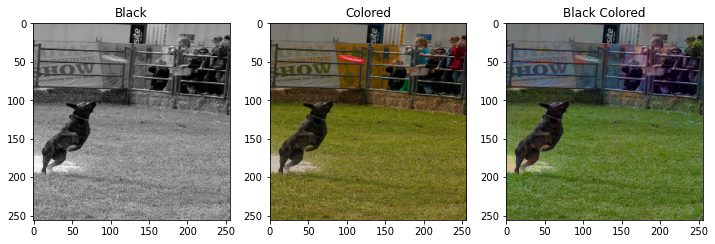

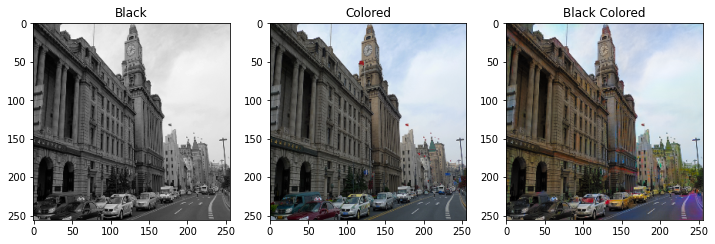

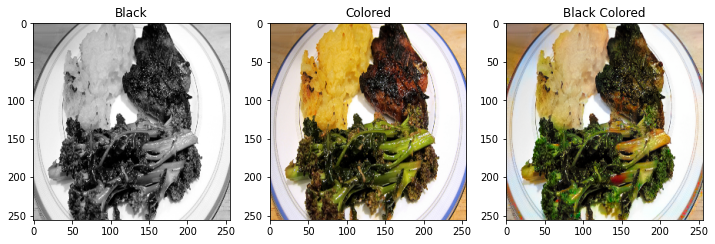

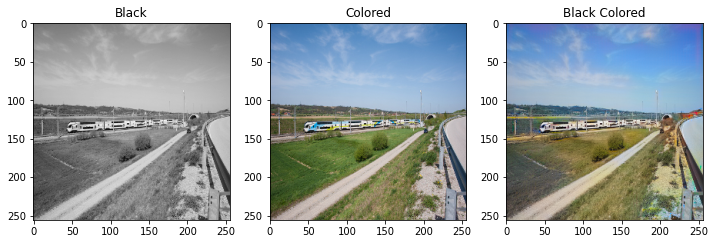

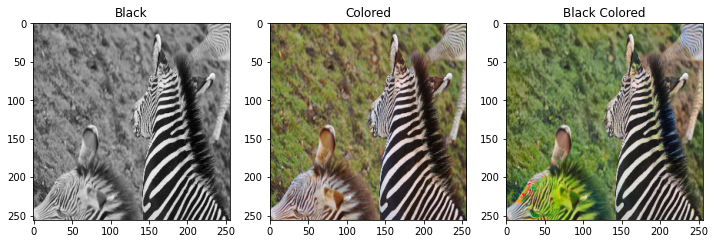

In [23]:
for _ in range(5): # LOCAL*
    test_show(generator)

#### As the author suggests we may use pretrained Unet model to retrain it on colorization task and only then use it in our above Unet-GAN implementation (just pass it to the train_one_batch, validate functions), which significantly improves the quality of colorization results

[https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8](http://)

#### For discriminator we also may use pretrained model, e.i. from torch.models., such as vgg16, resnet18, efficient_b0, etc.

In [ ]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet


def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in tqdm(range(epochs), total=epochs, leave=False):
        # train_dl, _ = gen_new_dataset(e)  # to use x2-3 samples
        for data in train_dl:
            L, ab = data
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
def pretrain_generatorW(net_G, train_dl, opt, criterion, epochs):
    for e in tqdm(range(epochs), total=epochs, leave=False):
        for data in train_dl:
            L, ab = data
            preds = net_G(L)
            image_real = torch.cat([L, ab], dim=1)
            image_rec = torch.cat([L, preds], dim=1)
            loss = criterion(image_rec, image_real) * loss_lambda
            opt.zero_grad()
            loss.backward()
            opt.step()
            
def pretrain_generator_cust(net_G, train_dl, opt, criterion, epochs):
    for e in tqdm(range(epochs), total=epochs, leave=False):
        for data in train_dl:
            L, ab = data
            preds = net_G(L)
            with torch.autograd.set_detect_anomaly(True):
                loss = criterion(L, ab, preds)
                opt.zero_grad()
                loss.backward()
                opt.step()

generator = build_res_unet(n_input=1, n_output=2, size=256)

# Already trained
opt = torch.optim.AdamW(generator.parameters(), lr=1e-4)

#criterion = nn.L1Loss() 
#pretrain_generator(generator, train_dataloader, opt, criterion, 20)
# pretrain_generatorW(generator, train_dataloader, opt, criterion_content, 20)  # criterion_content = compare ext. conv features

criterion = CustomLoss()
pretrain_generator_cust(generator, train_dataloader, opt, criterion, 20)

torch.save(generator.state_dict(), 'generator_c.pth')
#torch.save(generator.state_dict(), 'generator.pth')
# torch.save(generator.state_dict(), 'generatorW.pth')

In [42]:
generator.load_state_dict(torch.load('generator.pth'))  # generator with L1Loss for first approach 
#generator.load_state_dict(torch.load('generatorW.pth')) # generator for WGAN-GP

<All keys matched successfully>

#### As an experiment load pretrained classifier (maybe resnet18 would be better)

In [ ]:
!pip install -qq efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet

def get_d_model(sigmoid=True):
    model = EfficientNet.from_name('efficientnet-b0')
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model._fc.in_features
    layers = [nn.Linear(num_ftrs, 1), ]
    if sigmoid:
        layers.append(nn.Sigmoid())
    model._fc = nn.Sequential(*layers)
    return model.to(device)

discriminator = get_d_model(sigmoid=False)  # False for W-loss with grad penalty

#### Modified train function (multiple discriminator updates with BCE loss). Use it with generator, pretrained with L1Loss. Loss BCE+L1. Discriminator - from scratch.

In [14]:
def train_one_batch(generator, discriminator, data, criterion_content_loss, optimizerG, optimizerD, 
                    critic_updates=1, noise=False, std=1):
    if std <= 1e-4:
        noise=False
        
    generator.train()
    discriminator.train()

    grad_req(discriminator, True)
    L, ab = data
    
    tot_d_loss = 0.
    for _ in range(critic_updates):
        fake_color = generator(L)
        
        if noise:  # make discriminator training more complex to help generator
            alpha = torch.empty_like(fake_color, device=device).normal_(mean=0., std=std)
            fake_color = (fake_color + alpha).clamp_(min=-1., max=1.)
            beta = torch.empty_like(ab, device=device).normal_(mean=0., std=std)
            ab_ = torch.clamp(ab + beta, min=-1., max=1.)
            real_image = torch.cat([L, ab_], dim=1)
        else:
            real_image = torch.cat([L, ab], dim=1)
    
        fake_image = torch.cat([L, fake_color], dim=1)
        
        fake_preds = discriminator(fake_image.detach())
    
        optimizerD.zero_grad()

        real_preds = discriminator(real_image)
        kwargs = {
                  'color_discriminator_out': real_preds, 
                  'recon_discriminator_out': fake_preds,  
                 }
        d_loss = gan_logit_loss('D', 
                                smoothing=True, # set to True to apply one-sided label smoothing (only in 'D' step)
                                smooth_real_value='soft',  # hard smoothing = const value, to randomize [0.8, 1.) set 'soft'
                                func=nn.functional.binary_cross_entropy_with_logits,  # set Loss function for D_model
                                **kwargs)
        d_loss.backward(retain_graph=critic_updates>1)
        tot_d_loss += d_loss.item()
        optimizerD.step()
    tot_d_loss /= critic_updates
    
    grad_req(discriminator, False)
    optimizerG.zero_grad()
    
    fake_color = generator(L)
    fake_image = torch.cat([L, fake_color], dim=1)
    fake_preds = discriminator(fake_image)
    
    kwargs = {
              'recon_discriminator_out': fake_preds, 
              }    
    g_loss_gan = gan_logit_loss('G', 
                                smoothing=False, 
                                func=nn.functional.binary_cross_entropy_with_logits,
                                **kwargs)
    loss_G_L1 = criterion_content_loss(fake_color, ab) * loss_lambda
    g_loss = g_loss_gan + loss_G_L1
    g_loss.backward()
    optimizerG.step()

    torch.nn.utils.clip_grad_norm_(generator.parameters(), 10.0)  # the weights may increase we set (ep<1000): 1.0 - 10.0
    torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 10.0) # prevents from exploding grads
    
    with torch.no_grad():
        denorm_fake_color = fake_color.detach().cpu() * 110
        denorm_real_color = ab.detach().cpu() * 110
    metric = PSNR(denorm_fake_color, denorm_real_color)

    return tot_d_loss, g_loss.item(), metric

In [15]:
@torch.no_grad()
def validate(generator, discriminator, data, criterion_content_loss):
    generator.eval()
    discriminator.eval()

    L, ab = data
    
    fake_color = generator(L)
    fake_image = torch.cat([L, fake_color], dim=1)
    real_image = torch.cat([L, ab], dim=1)
    
    color_discriminator_out = discriminator(real_image)
    recon_discriminator_out = discriminator(fake_image)
    kwargs = {
              'color_discriminator_out': color_discriminator_out, 
              'recon_discriminator_out': recon_discriminator_out,  
             }
    d_loss = gan_logit_loss('D', 
                            smoothing=False,
                            func=nn.functional.binary_cross_entropy_with_logits,
                            **kwargs)
    
    kwargs = {
              'recon_discriminator_out': recon_discriminator_out, 
              }    
    g_loss_gan =  gan_logit_loss('G', 
                                 smoothing=False,
                                 func=nn.functional.binary_cross_entropy_with_logits,
                                 **kwargs)
    loss_G_L1 = criterion_content_loss(fake_color, ab) * loss_lambda 
    g_loss = g_loss_gan + loss_G_L1
    
    denorm_fake_color = fake_color.detach().cpu() * 110
    denorm_real_color = ab.detach().cpu() * 110
    metric = PSNR(denorm_fake_color, denorm_real_color)

    return d_loss.item(), g_loss.item(), metric

#### Other tips and tricks
**Minibatch discrimination**

When mode collapses, all images created looks similar. To mitigate the problem, we feed real images and generated images into the discriminator separately in different batches and compute the similarity of the image x with images in the same batch. We append the similarity o(x) in one of the dense layers in the discriminator to classify whether this image is real or generated.

If the mode starts to collapse, the similarity of generated images increases. The discriminator can use this score to detect generated images and penalize the generator if mode is collapsing.

**Experience replay**

The model optimization can be too greedy in defeating what the generator is currently generating. To address this problem, experience replay maintains the most recent generated images from the past optimization iterations. Instead of fitting the models with current generated images only, we feed the discriminator with all recent generated images also. Hence, the discriminator will not be overfitted for a particular time instance of the generator.

**Historical averaging**

In historical averaging, we keep track of the model parameters for the last t models. Alternatively, we update a running average of the model parameters if we need to keep a long sequence of models.

We add an L2 cost to the cost function to penalize model different from the historical average.

For GANs with non-convex object function, historical averaging may stop models circle around the equilibrium point and act as a damping force to converge the model.

https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b